Notebook to calculate the Fisher LSST detection of Kineticity

In [1]:
from classy import Class
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.integrate import simps
from scipy.special import erf

# Calculate the Cosmology

In [2]:
# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
"Omega_Lambda": 0,
"Omega_fld": 0,
"Omega_smg" : -1.,
"gravity_model" : "propto_omega",
"parameters_smg" : "1, 0, 0, 0, 1",
"expansion_model" : "lcdm",
"expansion_smg" : 0.75,
"tuning_index_smg" : 0,
"tuning_dxdy_guess_smg" : 1,
"number count contributions" : "density",
"temperature contributions": "tsw, eisw, lisw, dop, pol",
"selection" : "tophat",
#ask only one bin to make sure T-d is the right one!
"selection_mean" : "0.3", 
"selection_width" : 0.05,
"l_max_lss" : 1001,
"output" : "nCl, tCl",
"omega_cdm" : 0.11984,
"omega_b" : 0.02225,
"h": 0.6727,
"ln10^{10}A_s": 3.094,
"n_s" : 0.9645,
"k_pivot" : 0.05,
"tau_reio" : 0.079,
"YHe" : 0.24,
"skip_stability_tests_smg": "no",
"kineticity_safe_smg" : 1e-6,
#the following give problems, but they are set to default values
#"l_switch_limber_for_nc_local_over_z" : 10000.,
#"l_switch_limber_for_nc_los_over_z" : 1000.,
"selection_sampling_bessel" : .5,
"k_max_tau0_over_l_max" : 2.,
"q_linstep" : .5,
"start_small_k_at_tau_c_over_tau_h" : 1e-4,
"start_large_k_at_tau_h_over_tau_k" : 1e-4,
"perturb_sampling_stepsize" : 0.05,
"l_logstep" : 1.045,
"l_linstep" : 50
}

In [3]:
params["parameters_smg"]="1,0,0,0,1"

params["parameters_smg"]

'1,0,0,0,1'

In [4]:
# Create an instance of the CLASS wrapper
cosmos = Class()

In [5]:
# Set the parameters to the cosmological code
cosmos.set(params)

True

In [6]:
# Run the whole code. Depending on your output, it will call the
# CLASS modules more or less fast. For instance, without any
# output asked, CLASS will only compute background quantities,
# thus running almost instantaneously.
# This is equivalent to the beginning of the `main` routine of CLASS,
# with all the struct_init() methods called.
cosmos.compute()

In [14]:
# Clean CLASS (the equivalent of the struct_free() in the `main`
# of CLASS. This step is primordial when running in a loop over different
# cosmologies, as you will saturate your memory very fast if you ommit
# it.
cosmos.struct_cleanup()

In [15]:
# If you want to change completely the cosmology, you should also
# clean the arguments, otherwise, if you are simply running on a loop
# of different values for the same parameters, this step is not needed
cosmos.empty()

# Define the Tracers

### Background quantitites

In [16]:
background = cosmos.get_background()
#background.keys()
redshift = background['z']
Hubble = background['H [1/Mpc]']
growth_D = background['gr.fac. D']
growth_f = background['gr.fac. f']
comoving_dist = background[ 'comov. dist.']
background.keys()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ur', '(.)rho_crit', 'gr.fac. D', 'gr.fac. f', '(.)rho_smg', '(.)p_smg', 'M*^2_smg', 'D_M*^2_smg', 'kineticity_smg', 'braiding_smg', 'tensor_excess_smg', 'Mpl_running_smg', 'c_s^2', 'kin (D)'])

In [ ]:
def ell_max_at_z(redshift, comoving_dist, z, k_max):
    chi = interp1d(redshift, comoving_dist, kind='cubic') # interpolate the comoving distance as a function of z
    ell_max = k_max * chi(z) - 0.5  
    return ell_max

In [24]:
# define the bias 
def b_lsst(redshift, growth_D, z, b0=0.95):
    D = interp1d(redshift, growth_D, kind='cubic') # interpolate the growth function as a function of z
    b = b0 / D(z)
    return b

In [ ]:
# define the photo z error
def photoz_error(z, sigma_z0=0.03):
    return sigma_z0*(1+z)

In [ ]:
def dN_dz(z, z0=0.28, alpha=0.9, ngal_arcmin_minus2=48.):
    """LSST DESC SRD Mandelbaum et al. (2018), arXiv:1809.01669"""
    norm = 1/60 * ngal_arcmin_minus2  # in arcmin^-2 # FIXME: Normalization breaks for other params.
    dndz = norm * z**2. * np.exp(-z/z0)**alpha
    return dndz  # in arcmin^-2

In [125]:
def Ngal_lsst_gold(fmask=0.12, i_maglim=25.3):
    return 42.9*(1 - fmask)*10**(0.359*(i_maglim - 25))  # in arcmin^-2

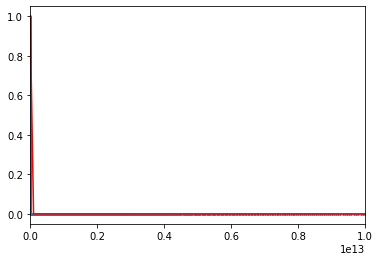

In [124]:
x = redshift[0:10000]
y = growth_D[0:10000]
D = interp1d(redshift, growth_D, kind='cubic')
xnew = np.linspace(x[0], x[-1], 1000)
ynew = D(xnew)   # use interpolation function returned by `interp1d`
#plt.plot(x, y, 'o', xnew, ynew, '-')
plt.scatter(x, 1.0 * y, s=3)
plt.plot(xnew, ynew, '-',color='r')
#plt.ylim(0.0 , 5 / np.power(10,4))
plt.xlim(0. * np.power(10,14), 0.1 * np.power(10,14))
plt.show()

In [69]:
y

array([5.54090847e-20, 7.73024744e-08, 1.54604949e-07, ...,
       9.92766775e-01, 9.96479926e-01, 1.00000000e+00])

In [93]:
np.power(10,14)

100000000000000